<a href="https://colab.research.google.com/github/dorin133/Machine-Learning-236756-all-HW/blob/master/HW3%20-%20236756.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Imports**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.spatial import distance
import sklearn.datasets as ds
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import PolynomialFeatures

#For section 2
from sklearn.base import BaseEstimator, RegressorMixin
#For Q6
from sklearn.dummy import DummyRegressor
#For Q7
from sklearn.linear_model import Ridge
#  For Q11
from sklearn.linear_model import Lasso

pd.options.mode.chained_assignment = None

## **Data Loading and preprocessing**

In [ ]:
!rm *.csv

from google.colab import files
print("Please load the raw csv data")
uploadedData = files.upload()
filename = list(uploadedData)[0]
#for our usage
dataset = pd.read_csv('virus_labeled.csv', sep=',', header=0)

rm: cannot remove '*.csv': No such file or directory
Please load the raw csv data


Saving virus_labeled.csv to virus_labeled.csv


In [ ]:
#Import the split method, and split the data. random_state=1+2=3 (from our ID numbers)
from sklearn.model_selection import train_test_split
data_training_set, data_test_set = train_test_split(dataset, test_size=0.2, train_size=0.8, random_state=3)

In [ ]:
def MinMaxNorm(copy_dataset, dataset_train, colName):
  scaler2 = MinMaxScaler()
  scaler2.fit(pd.DataFrame(dataset_train[colName]))
  temp_df = pd.DataFrame(scaler2.transform(pd.DataFrame(copy_dataset[colName])))
  copy_dataset[colName] = temp_df.iloc[:,[True]]

def ZScoreNorm(copy_dataset, dataset_train, colName):
  scaler2 = StandardScaler()
  scaler2.fit(pd.DataFrame(dataset_train[colName]))
  temp_df = pd.DataFrame(scaler2.transform(pd.DataFrame(copy_dataset[colName])))
  copy_dataset[colName] = temp_df.iloc[:,[True]]

#hypothesis for usage in practice: X=age, Y=weight
#Function to clean contextual outliers.
def outlier_Y_by_X(copy_set, train_set,X,Y):
  x_range = train_set[X].unique()
  for x in x_range:
    Q3=train_set[train_set[X]==x][Y].quantile(0.75)
    Q1=train_set[train_set[X]==x][Y].quantile(0.25)
    max=((Q3-Q1)*1.5+Q3) 
    min=(Q1-(Q3-Q1)*1.5)
    copy_set[Y][(copy_set[X]==x) & (copy_set[Y]>max)] = max
    copy_set[Y][(copy_set[X]==x) & (copy_set[Y]<min)] = min

#editing and preparing on a copy of 'data' based on 'training_data'
def prepare_data(data, data_training) :
  np.random.seed(0)
  data_copy = data.copy()
  data_copy = data_copy.reset_index()
  data_copy = data_copy.drop(['index'], axis=1)

  # final features in data_copy (based on Q23): 
  # patient_id, num_of_siblings, A+, O+, A-, cough, fever, shortness_of_breath, sugar_levels, household_income, PCR_01, PCR_02, PCR_03, PCR_04, PCR_05, PCR_07 PCR_10

  # STEP 1: drop irrelevant columns

  # drop irrelevant columns
  data_copy = data_copy.drop(['sex', 'happiness_score','sport_activity','conversations_per_day',
                              'current_location', 'address', 'job'], inplace = False, axis=1)

  # STEP 2: cleaning relevant outliers - based on pcr_date
    
  #Finding limits for later Capping method like in Q13
  df_PCR = data_training[["patient_id","pcr_date","PCR_01", "PCR_02", "PCR_03", "PCR_04", "PCR_05", "PCR_06", "PCR_07","PCR_08", "PCR_09", "PCR_10"]]
  df_PCR_outliers= df_PCR.copy()

  #create the fisrt outliers' table for PCR_01
  percentile25 = df_PCR['PCR_01'].quantile(0.25)
  percentile75 = df_PCR['PCR_01'].quantile(0.75)
  iqr = percentile75 - percentile25

  upper_limit = percentile75 + 1.5 * iqr
  lower_limit = percentile25 - 1.5 * iqr
  df_PCR_outliers = df_PCR[(df_PCR['PCR_01']>upper_limit) | (df_PCR['PCR_01'] <lower_limit)]

  #do the others in loop for finding outliers from at least one PCR test
  for (columnName, columnData) in df_PCR.iteritems():
    if (columnName == 'pcr_date' or columnName == 'patient_id'):
      continue
    df_PCR_temp = df_PCR.copy()
    percentile25 = columnData.quantile(0.25)
    percentile75 = columnData.quantile(0.75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    #The actual Capping part
    df_PCR_temp = df_PCR[(df_PCR[columnName]>upper_limit) | (df_PCR[columnName] <lower_limit)]
    df_PCR_outliers = pd.concat([df_PCR_outliers,df_PCR_temp]).drop_duplicates().reset_index(drop=True)


  #extract a dataset of subjects with normal PCR tests 
  df_PCR_normal= df_PCR.copy()
  df_PCR_normal = df_PCR[~df_PCR['patient_id'].isin(df_PCR_outliers['patient_id'])]
  outliers_counts = df_PCR_outliers.pcr_date.value_counts()
  normal_counts = df_PCR_normal.pcr_date.value_counts()
  normal_counts.rename("normal_pcr", inplace=True)
  outliers_counts.rename("outliers_pcr", inplace=True)
  result = pd.concat([outliers_counts, normal_counts], axis=1, join= "outer")
  result['normal_pcr'] = result['normal_pcr'].fillna(0)
  result['outliers_pcr'] = result['outliers_pcr'].fillna(0)
  result['ratio'] = result['outliers_pcr']/(result['outliers_pcr']+result['normal_pcr'])
  result['date'] = result.index

  #iterate the result table, find bad_ratio dates, and put Nan in the corresponding PCR_xx for these dates in data_..._override
  #later on, in imputation, we'll fill them back with other values
  bad_ratio = 0.7
  for index, row in result.iterrows() :
    if (row['ratio']> bad_ratio) :
      data_copy['PCR_01'] = np.where(data_copy['pcr_date'] == row.date, np.NaN , data_copy['PCR_01'])
      data_copy['PCR_02'] = np.where(data_copy['pcr_date'] == row.date, np.NaN , data_copy['PCR_02'])
      data_copy['PCR_03'] = np.where(data_copy['pcr_date'] == row.date, np.NaN , data_copy['PCR_03'])
      data_copy['PCR_04'] = np.where(data_copy['pcr_date'] == row.date, np.NaN , data_copy['PCR_04'])
      data_copy['PCR_05'] = np.where(data_copy['pcr_date'] == row.date, np.NaN , data_copy['PCR_05'])
      data_copy['PCR_06'] = np.where(data_copy['pcr_date'] == row.date, np.NaN , data_copy['PCR_06'])
      data_copy['PCR_07'] = np.where(data_copy['pcr_date'] == row.date, np.NaN , data_copy['PCR_07'])
      data_copy['PCR_08'] = np.where(data_copy['pcr_date'] == row.date, np.NaN , data_copy['PCR_08'])
      data_copy['PCR_09'] = np.where(data_copy['pcr_date'] == row.date, np.NaN , data_copy['PCR_09'])
      data_copy['PCR_10'] = np.where(data_copy['pcr_date'] == row.date, np.NaN , data_copy['PCR_10'])
  # cleaning bi-variant outliers
  outlier_Y_by_X(data_copy, data_training, 'age', 'weight')
  outlier_Y_by_X(data_copy, data_training, 'weight', 'sugar_levels')
  # STEP 3: cleaning relevant outliers of COL_NAME_5 - capping 
  COL_NAME_5 = ["PCR_01", "PCR_02", "PCR_03", "PCR_04", "PCR_05","PCR_07" ,"PCR_10", "sugar_levels" , "household_income"]
  for columnName in COL_NAME_5:
    percentile25 = data_training[columnName].quantile(0.25)
    percentile75 = data_training[columnName].quantile(0.75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    #The actual Capping part
    data_copy[columnName] = np.where(data_copy[columnName] > upper_limit, upper_limit, np.where(data_copy[columnName] < lower_limit,lower_limit, data_copy[columnName]))

  # STEP 4: Imputation of missing data - MMI
  for variable in COL_NAME_5:
    #data_copy.assign(median=data_copy[variable])
    # print(variable)

    # data_copy[variable+'_median'] = data_copy[variable]#Copy feature into new feature
        
    #calculate random sample and store into random_sample_values
    median_value = round(data_training[variable].dropna().median(), 6)
    data_copy[variable] = data_copy[variable].fillna(median_value)
    # data_copy[variable+'_median'] = data_copy[variable].fillna(median_value)
    # #copy from imputed column to original column, and remove imputed added column
    # data_copy[variable] = data_copy[variable+'_median']
    # data_copy = data_copy.drop(variable+'_median', 1, inplace = True)


  # STEP 5: Imputation of missing data - RSI
  # Random sample imputation function for missing values, using RSI method.
  COL_NAME_6 = ['blood_type', 'num_of_siblings']
  for variable in COL_NAME_6:
    # data_copy[variable+'_random'] = data_copy[variable]#Copy feature into new feature
    #calculate random sample and store into random_sample_values
    random_sample_value = data_training[variable].dropna().sample(data_copy[variable].isnull().sum())    
    #in random_sample_value all filled nan values are present now we want to put/merge this all filled values in our dataset
    # for this we want to match all nan values index in random_sample_values with df[variavle_'random] 
    #Pandas need to have same index in order to merge dataset
    random_sample_value.index = data_copy[data_copy[variable].isnull()].index #find index of NaN values in feature
    #now put a condition where ever it is null with loc function then replace with random_sample_values
    data_copy.loc[data_copy[variable].isnull(),variable] =random_sample_value
    #copy from imputed column to original column, and remove imputed added column
    #data_copy[variable] = data_copy[variable+'_random']
    #data_copy = data_copy.drop(variable+'_random', 1, inplace = True) 

  #STEP 5.5: Normalize Min-Max features for HW2 Q8
  MinMaxNorm(data_copy,data_training,'num_of_siblings')
  MinMaxNorm(data_copy,data_training,'household_income')

  #STEP 5.5b: Normalize Z-score features for HW2 Q8
  ZScoreNorm(data_copy,data_training,'PCR_01')
  ZScoreNorm(data_copy,data_training,'PCR_02')
  ZScoreNorm(data_copy,data_training,'PCR_03')
  ZScoreNorm(data_copy,data_training,'PCR_04')
  ZScoreNorm(data_copy,data_training,'PCR_05')
  ZScoreNorm(data_copy,data_training,'PCR_07')
  ZScoreNorm(data_copy,data_training,'PCR_10')
  ZScoreNorm(data_copy,data_training,'sugar_levels')

  # STEP 6: make an OHE vector for blood_type and symptoms 
  # make the categorial variable 'blood_type' an OHE vector 
  # For this Targil we won't do that, since we don't need to
  # temp = pd.get_dummies(data_copy.blood_type)
  # data_copy = pd.concat([temp, data_copy], axis=1, join="inner")

  #make the variable 'symptoms' an OHE vector 
  temp = data_copy.symptoms.str.get_dummies(sep =';')
  data_copy = pd.concat([temp, data_copy], axis=1, join="inner")

  # STEP 7: drop some more irrelevant columns ('blood_type', 'symptoms', 'pcr_date')
  data_copy = data_copy.drop([ 'symptoms', 'pcr_date','weight', 'age'], 1)
  data_copy = data_copy.drop(['headache', 'low_appetite', 'PCR_06', 'PCR_08', 'PCR_09'], 1)
  # We used to drop this, but now we don't even make it, so why should we??
  # data_copy = data_copy.drop(['B+', 'B-', 'AB+', 'AB-', 'O-'], 1)
  
  # STEP 8: return
  return data_copy

In [ ]:
# Clean training set according to itself
train_df_clean = prepare_data(data_training_set, data_training_set)
# Clean test set according to the raw training set
test_df_clean = prepare_data(data_test_set, data_training_set)

## **Section 1 - Quick data exploration and preparation**

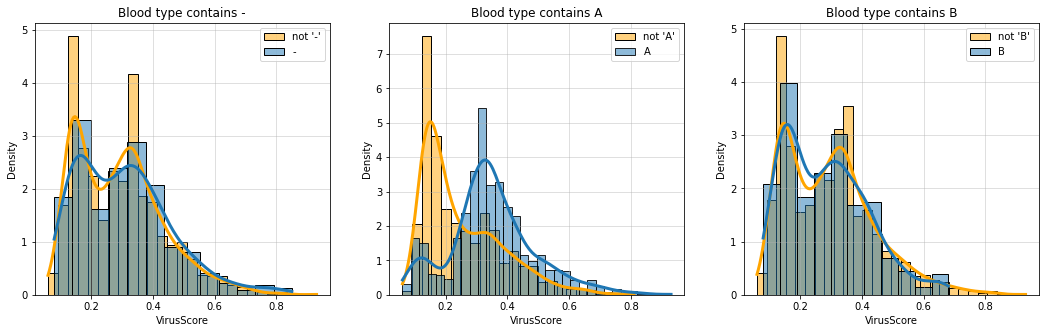

In [ ]:
#Histograms for Q1 and Q2:

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
for i, cur_type in enumerate(['-', 'A', 'B']):
 filter_mask = train_df_clean['blood_type'].str.contains(cur_type)
 sns.histplot(data=train_df_clean['VirusScore'][~filter_mask], ax=ax[i], stat="density", kde=True,
              line_kws={"linewidth": 3}, color="orange", label="not '{}'".format(cur_type))
 sns.histplot(data=train_df_clean['VirusScore'][filter_mask], ax=ax[i], stat="density", kde=True,
              line_kws={"linewidth": 3}, label=cur_type)
 ax[i].set_title("Blood type contains " + cur_type)
 ax[i].legend(), ax[i].grid(alpha=0.5)

In [ ]:
#For Task after Q2.
#Creating new column for bloodtypes contains A or not, as well as drop 'blood_type' column:

#Create the new column
train_df_clean['containsA'] = train_df_clean['blood_type'].str.contains('A')
test_df_clean['containsA'] = test_df_clean['blood_type'].str.contains('A')
train_df_clean['containsA'] = train_df_clean['containsA'].astype(int)
test_df_clean['containsA'] = test_df_clean['containsA'].astype(int)
#Drop the blood_type column
train_df_clean = train_df_clean.drop(['blood_type'], 1)
test_df_clean = test_df_clean.drop(['blood_type'], 1)

## **Section 2 - Linear regression implementation**

In [ ]:
#Split training set to train and validation for section 2
new_training_set, new_validation_set = train_test_split(train_df_clean, test_size=0.2, train_size=0.8, random_state=3)

In [ ]:
#Class of Linear regressor for fun.

class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """
    def __init__(self, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """

        # TODO: complete the loss calculation
        loss = None
        loss = np.linalg.norm(X@w+b-y)
        loss = loss**2
        loss = loss/(y.size)

        return loss

    @staticmethod
    def gradient(w, b: float, X, y):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # TODO: calculate the analytical gradient w.r.t w and b
        g_w = None
        g_b = 0.0
        g_b = 2*(X@w+b-y)

        g_b = g_b/(y.size)

        g_w = g_b

        g_b = np.sum(g_b)
        g_w = (X.T)@g_w

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val  =None, y_val = None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # TODO: Compute the gradient for the current *batch*
            g_w, g_b = self.gradient(self.w, self.b, batch_X, batch_y)

            # Perform a gradient step
            # TODO: update the learned parameters correctly
            self.w = self.w - self.lr*g_w
            self.b = self.b - self.lr*g_b

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """

        # TODO: Compute
        y_pred = X@(self.w) + self.b

        return y_pred

In [ ]:
#Code to verify the crap we just wrote

def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()


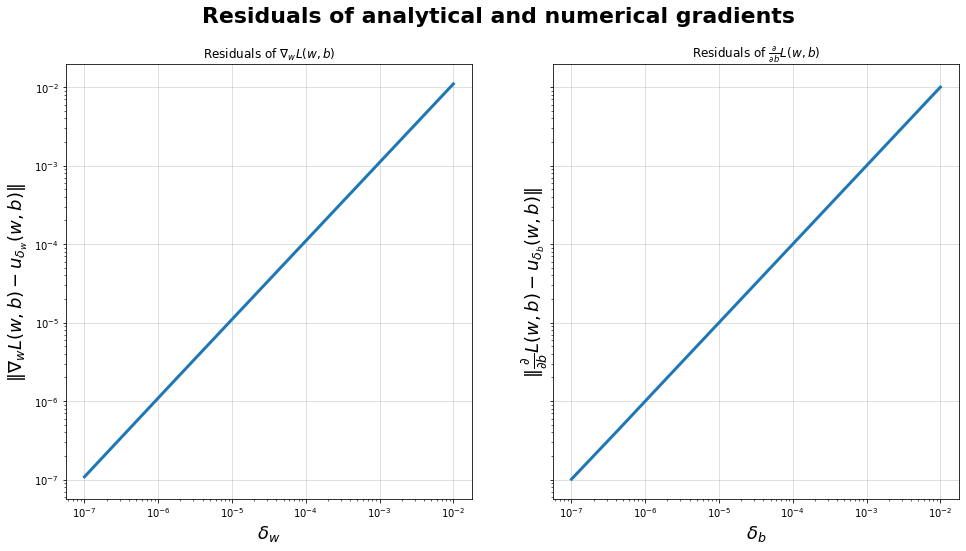

In [ ]:
#For Q4:

X_train = new_training_set.copy()
X_train = X_train.drop(['patient_id', 'VirusScore'], axis=1)

compare_gradients(X_train.to_numpy(), new_training_set.VirusScore.to_numpy(), deltas=np.logspace(-7, -2, 9))

In [ ]:
#Given code for Q5

def test_lr(X_train, y_train, X_val, y_val, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5)
  
  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')


lr size = 1e-09, Best train loss = 0.10707739735587236, Best validation loss = 0.10105028820530328
lr size = 1e-08, Best train loss = 0.10707038010478233, Best validation loss = 0.10104350734469754
lr size = 1e-07, Best train loss = 0.10700023689541681, Best validation loss = 0.10097572760522783
lr size = 1e-06, Best train loss = 0.10630172670207765, Best validation loss = 0.10030080865787741
lr size = 1e-05, Best train loss = 0.09960073366728815, Best validation loss = 0.09383142455153207
lr size = 0.0001, Best train loss = 0.05438524388432793, Best validation loss = 0.05054304920260102
lr size = 0.001, Best train loss = 0.012551272721044152, Best validation loss = 0.013161818791448456
lr size = 0.01, Best train loss = 0.00888291396679987, Best validation loss = 0.010076262466397597
lr size = 0.1, Best train loss = 0.008489773919989847, Best validation loss = 0.009844749474549325


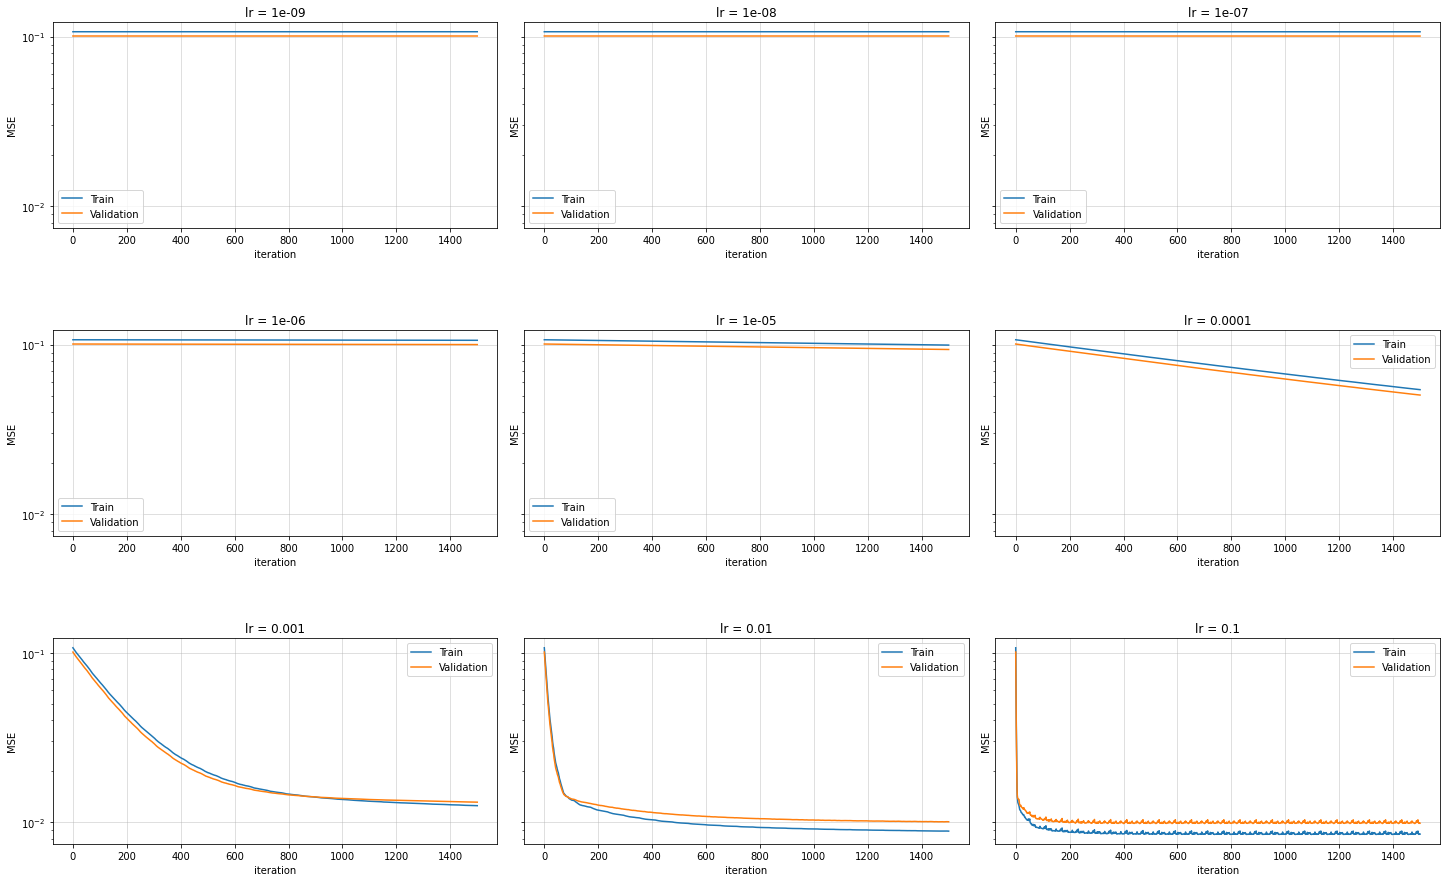

In [ ]:
#For Q5:

X_val = new_validation_set.copy()
X_val = X_val.drop(['patient_id', 'VirusScore'], axis=1)

_= test_lr(X_train.to_numpy(), new_training_set.VirusScore.to_numpy(), X_val.to_numpy(), new_validation_set.VirusScore.to_numpy())

## **Section 3 -  Evaluation and Baseline**

In [ ]:
#For Q6:

#Creating dummy regressor
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train.to_numpy(), new_training_set.VirusScore.to_numpy())
#Cross-fold validation
cv_results = cross_validate(dummy_regr, X_train.to_numpy(), new_training_set.VirusScore.to_numpy(), cv=5, return_train_score=True, scoring='neg_mean_squared_error')
dum_val_score = cv_results['test_score'].mean()
dum_train_score = cv_results['train_score'].mean()

In [ ]:
print("train score of cross-validate is " + str(dum_train_score))
print("validation score of cross-validate is " + str(dum_val_score))

train score of cross-validate is -0.02058912914699978
validation score of cross-validate is -0.020660172475179036


In [ ]:
#Task from Q6 for later use in section 7:

X_train_clean = train_df_clean.copy()
X_train_clean = X_train_clean.drop(['patient_id', 'VirusScore'], axis=1)


#Creating dummy regressor
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train_clean.to_numpy(), train_df_clean.VirusScore.to_numpy())
#Cross-fold validation
cv_results = cross_validate(dummy_regr, X_train_clean.to_numpy(), train_df_clean.VirusScore.to_numpy(), cv=5, return_train_score=True, scoring='neg_mean_squared_error')
dum_val_score = np.abs(cv_results['test_score'].mean())
dum_train_score = np.abs(cv_results['train_score'].mean())

In [ ]:
print("train score of full train df is " + str(dum_train_score))
print("validation score of full train df is " + str(dum_val_score))

train score of full train df is 0.02001108412543403
validation score of full train df is 0.020040073426649308


In [ ]:
clf_dummy_train = DummyRegressor(strategy="mean")
_ = clf_dummy_train.fit(X_train_clean.to_numpy(), train_df_clean.VirusScore.to_numpy())

## **Section 4: Ridge linear regression**

In [ ]:
#For Q7:
index_arr = np.logspace(-2, 6, 50)
test_scores_y = np.zeros(50)
train_scores_y = np.zeros(50)
i=0

for k in np.logspace(-2, 6, 50):
  clf_ridge = Ridge(alpha=k)
  clf_ridge.fit(X_train_clean.to_numpy(), train_df_clean.VirusScore.to_numpy())
  cv_results = cross_validate(clf_ridge, X_train_clean.to_numpy(), train_df_clean.VirusScore.to_numpy(), cv=5, return_train_score=True, scoring='neg_mean_squared_error')
  test_scores_y[i] = np.abs(cv_results['test_score'].mean())
  train_scores_y[i] = np.abs(cv_results['train_score'].mean())
  i+=1
print("best score for train is " + str(np.min(train_scores_y)) + " and its achieved in index " + str(np.argmin(train_scores_y)))
print("best score for validation is " + str(np.min(test_scores_y)) + " and its achieved in index " + str(np.argmin(test_scores_y)))

best score for train is 0.008728997245164022 and its achieved in index 0
best score for validation is 0.008887456311043613 and its achieved in index 12


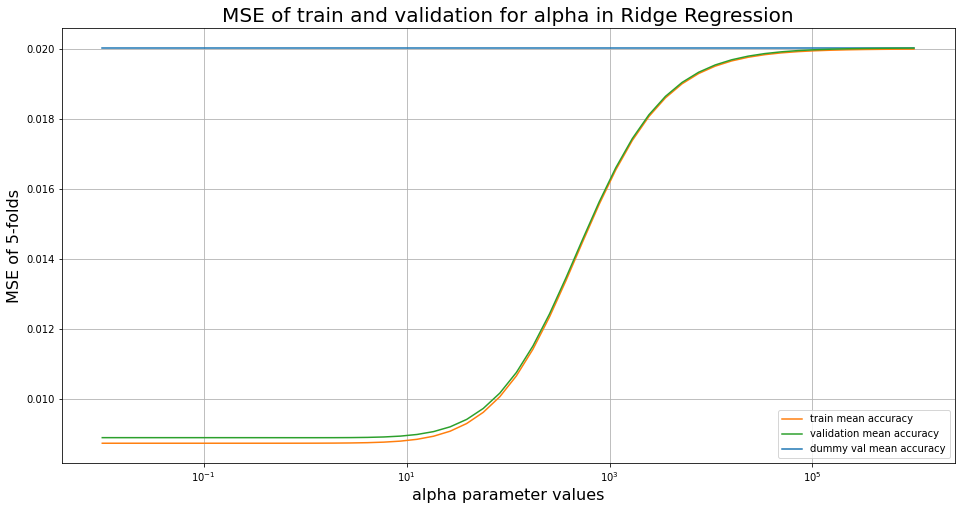

In [ ]:
#Plotting for 7:
index_arr = np.logspace(-2, 6, 50)
dummy_y = np.full(index_arr.size, dum_val_score) 
# Plotting the Graph
plt.figure(figsize=(16, 8))
plt_dummy, = plt.plot(index_arr, dummy_y , label="dummy val mean accuracy")
plt_train, = plt.plot(index_arr, train_scores_y, label="train mean accuracy")
plt_test, = plt.plot(index_arr, test_scores_y, label="validation mean accuracy")
plt.legend(handles=[plt_train,plt_test, plt_dummy])
plt.title("MSE of train and validation for alpha in Ridge Regression", fontsize=20)
plt.xlabel("alpha parameter values", fontsize = 16)
plt.ylabel("MSE of 5-folds", fontsize = 16)
plt.xscale('log')
plt.grid()
plt.show()

In [ ]:
# for Q8
best_alpha_ridge = index_arr[np.argmin(test_scores_y)]
clf_ridge_train = Ridge(alpha=best_alpha_ridge)
clf_ridge_train.fit(X_train_clean.to_numpy(), train_df_clean.VirusScore.to_numpy())

Ridge(alpha=0.9102981779915218)

In [ ]:
# Q9 - fincing the most important coe.
# save for later use (section 7)
ind = np.argpartition(np.abs(clf_ridge_train.coef_), 5)[-5:]
print("The best coefficients in descending order are: \n")
best_attr_by_coe = X_train_clean.columns[clf_ridge_train.coef_.argsort()[-5::]][::-1]

for i in range(5) :
  print(best_attr_by_coe[i])

The best coefficients in descending order are: 

num_of_siblings
shortness_of_breath
fever
containsA
cough


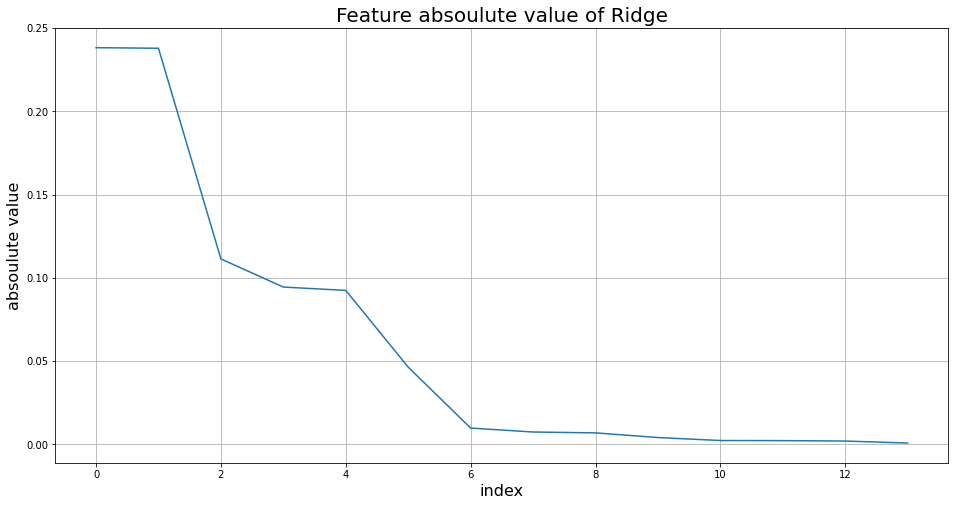

In [ ]:
# Q10 - plotting the coeffidients from largest to smallest
all_sorted_coe = np.sort(np.abs(clf_ridge_train.coef_))[::-1]
indeces = np.arange(all_sorted_coe.size)
plt.figure(figsize=(16, 8))
plt.plot(indeces , all_sorted_coe)
plt.xlabel("index", fontsize = 16)
plt.ylabel("absoulute value", fontsize = 16)
plt.title("Feature absoulute value of Ridge", fontsize=20)
plt.grid()
plt.show()

In [ ]:
#For Q11:
index_arr = np.logspace(-6, 2, 9)
test_scores_y = np.zeros(9)
train_scores_y = np.zeros(9)
i=0

for k in np.logspace(-6, 2, 9):
  clf_lasso = Lasso(alpha=k)
  clf_lasso.fit(X_train_clean.to_numpy(), train_df_clean.VirusScore.to_numpy())
  cv_results = cross_validate(clf_lasso, X_train_clean.to_numpy(), train_df_clean.VirusScore.to_numpy(), cv=5, return_train_score=True, scoring='neg_mean_squared_error')
  test_scores_y[i] = np.abs(cv_results['test_score'].mean())
  train_scores_y[i] = np.abs(cv_results['train_score'].mean())
  i+=1
print("best score for train is " + str(np.min(train_scores_y)) + " and its achieved in index " + str(np.argmin(train_scores_y)))
print("best score for validation is " + str(np.min(test_scores_y)) + " and its achieved in index " + str(np.argmin(test_scores_y)))

best score for train is 0.008728997389071309 and its achieved in index 0
best score for validation is 0.008878029704410883 and its achieved in index 2


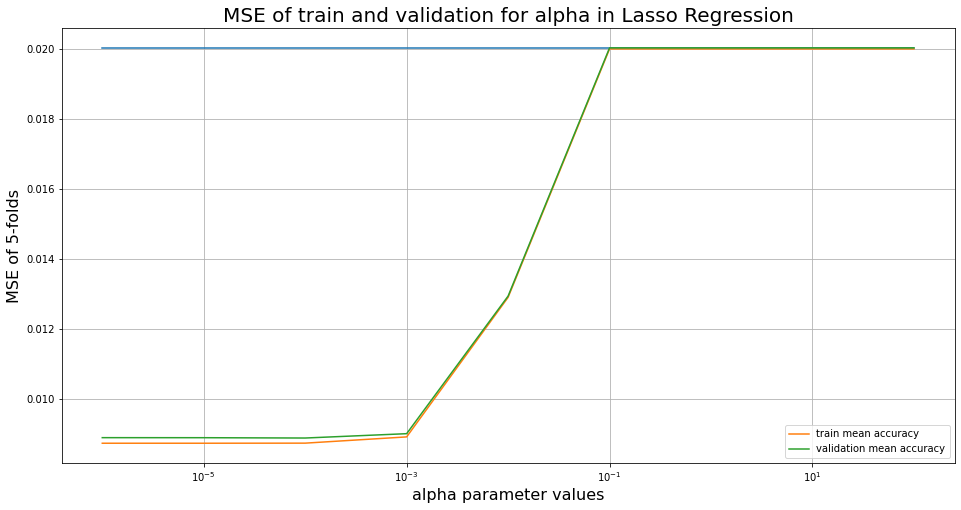

In [ ]:
#Plotting for Q11:
index_arr = np.logspace(-6, 2, 9)
dummy_y = np.full(index_arr.size, dum_val_score)
# Plotting the Graph
plt.figure(figsize=(16, 8))
plt_dummy, = plt.plot(index_arr, dummy_y , label="dummy val mean accuracy")
plt_train, = plt.plot(index_arr, train_scores_y, label="train mean accuracy")
plt_test, = plt.plot(index_arr, test_scores_y, label="validation mean accuracy")
plt.legend(handles=[plt_train,plt_test])
plt.title("MSE of train and validation for alpha in Lasso Regression", fontsize=20)
plt.xlabel("alpha parameter values", fontsize = 16)
plt.ylabel("MSE of 5-folds", fontsize = 16)
plt.xscale('log')
plt.grid()
plt.show()

In [ ]:
# for Q13
best_alpha_lasso = index_arr[np.argmin(test_scores_y)]
clf_lasso_train = Lasso(alpha=best_alpha_lasso)
clf_lasso_train.fit(X_train_clean.to_numpy(), train_df_clean.VirusScore.to_numpy())

Lasso(alpha=0.0001)

In [ ]:
# Q14 - fincing the most important coe.
# save for later use (section 7)
ind = np.argpartition(np.abs(clf_lasso_train.coef_), 5)[-5:]
print("The best coefficients in descending order are: \n")
best_attr_by_coe = X_train_clean.columns[clf_lasso_train.coef_.argsort()[-5::]][::-1]

for i in range(5) :
  print(best_attr_by_coe[i])

The best coefficients in descending order are: 

shortness_of_breath
num_of_siblings
fever
containsA
cough


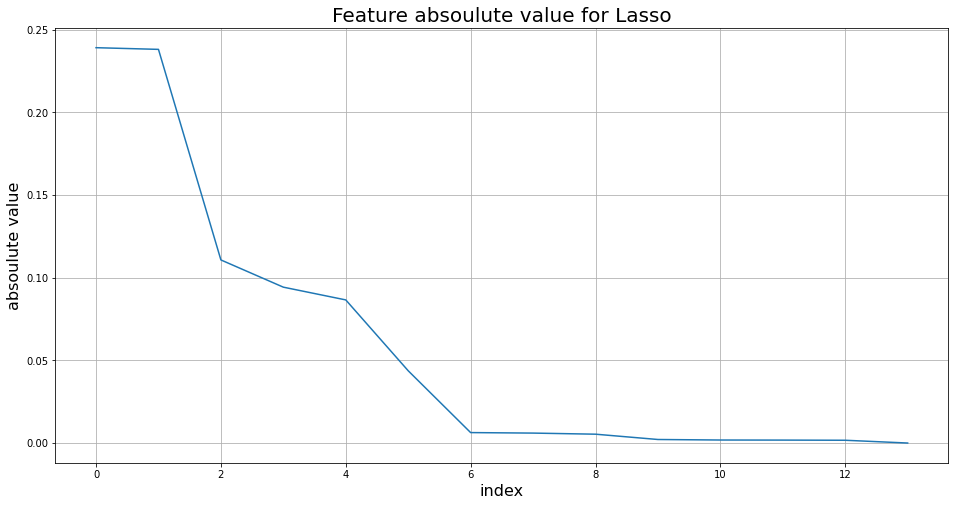

In [ ]:
# Q15 - plotting the coeffidients from largest to smallest
all_sorted_coe = np.sort(np.abs(clf_lasso_train.coef_))[::-1]
indeces = np.arange(all_sorted_coe.size)
plt.figure(figsize=(16, 8))
plt.plot(indeces , all_sorted_coe)
plt.xlabel("index", fontsize = 16)
plt.ylabel("absoulute value", fontsize = 16)
plt.title("Feature absoulute value for Lasso", fontsize=20)
plt.grid()
plt.show()

In [ ]:
#For Q18:
#prepare the poly_featurs for SVM
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X_train_clean.to_numpy())

index_arr = np.logspace(-3, 6, 10)
test_scores_y = np.zeros(10)
train_scores_y = np.zeros(10)
i=0

for k in np.logspace(-3, 6, 10):
  clf_ridge_poly = Ridge(alpha=k)
  clf_ridge_poly.fit(poly_features, train_df_clean.VirusScore.to_numpy())
  cv_results = cross_validate(clf_ridge_poly, poly_features, train_df_clean.VirusScore.to_numpy(), cv=5, return_train_score=True, scoring='neg_mean_squared_error')
  test_scores_y[i] = np.abs(cv_results['test_score'].mean())
  train_scores_y[i] = np.abs(cv_results['train_score'].mean())
  i+=1
print("best score for train is " + str(np.min(train_scores_y)) + " and its achieved in index " + str(np.argmin(train_scores_y)))
print("best score for validation is " + str(np.min(test_scores_y)) + " and its achieved in index " + str(np.argmin(test_scores_y)))

best score for train is 0.006766819191878002 and its achieved in index 0
best score for validation is 0.007755076065414826 and its achieved in index 3


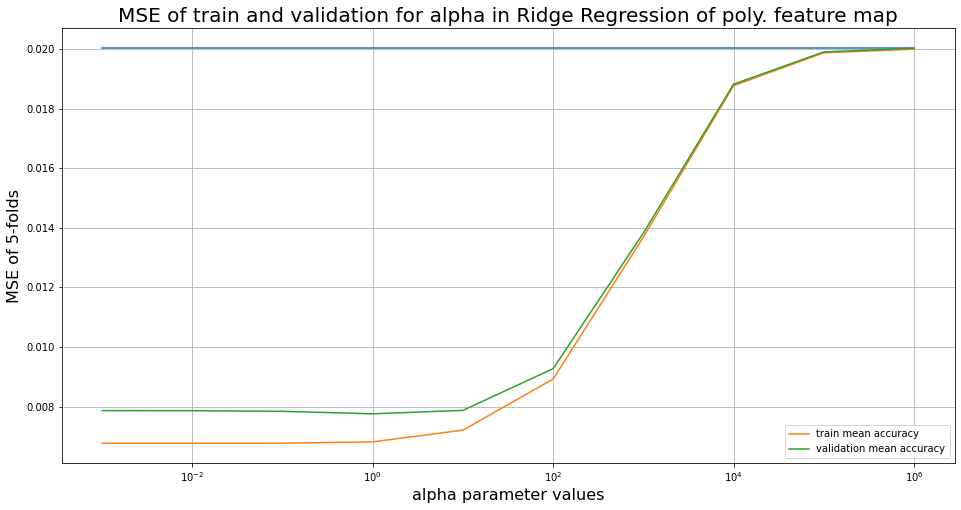

In [ ]:
#Plotting for Q19:
index_arr = np.logspace(-3, 6, 10)
dummy_y = np.full(index_arr.size, dum_val_score)
# Plotting the Graph
plt.figure(figsize=(16, 8))
plt_dummy, = plt.plot(index_arr, dummy_y, label="dummy val mean accuracy") 
plt_train, = plt.plot(index_arr, train_scores_y, label="train mean accuracy")
plt_test, = plt.plot(index_arr, test_scores_y, label="validation mean accuracy")
plt.legend(handles=[plt_train,plt_test])
plt.title("MSE of train and validation for alpha in Ridge Regression of poly. feature map", fontsize=20)
plt.xlabel("alpha parameter values", fontsize = 16)
plt.ylabel("MSE of 5-folds", fontsize = 16)
plt.xscale('log')
plt.grid()
plt.show()

In [ ]:
# for Q19
best_alpha_ridge_poly = index_arr[np.argmin(test_scores_y)]
clf_ridge_poly_train = Ridge(alpha=best_alpha_ridge_poly)
clf_ridge_poly_train.fit(poly_features, train_df_clean.VirusScore.to_numpy())
print(best_alpha_ridge_poly)

1.0


In [ ]:
# Q20
test_df_clean_copy = test_df_clean.copy() 
test_df_clean_copy = test_df_clean_copy.drop(['patient_id', 'VirusScore'], axis=1)

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(test_df_clean_copy.to_numpy())

print((np.square(np.subtract(clf_dummy_train.predict(test_df_clean_copy.to_numpy()), test_df_clean['VirusScore'])).mean()))
print((np.square(np.subtract(clf_ridge_train.predict(test_df_clean_copy.to_numpy()), test_df_clean['VirusScore'])).mean()))
print((np.square(np.subtract(clf_lasso_train.predict(test_df_clean_copy.to_numpy()), test_df_clean['VirusScore'])).mean()))
print((np.square(np.subtract(clf_ridge_poly_train.predict(poly_features), test_df_clean['VirusScore'])).mean()))

0.021396513611111067
0.00860815904694076
0.008590659485452684
0.00747779774804625


## **Section 9: Submitted model predictions**

In [ ]:
#Loading the unlabeled dataset

!rm *.csv

from google.colab import files
print("Please load the raw csv data")
uploadedData = files.upload()
filename = list(uploadedData)[0]
#for our usage
unlabeled_dataset = pd.read_csv('virus_unlabeled.csv', sep=',', header=0)

Please load the raw csv data


Saving virus_unlabeled.csv to virus_unlabeled.csv


In [ ]:
#Loading the labeled dataset

!rm *.csv

from google.colab import files
print("Please load the raw csv data")
uploadedData = files.upload()
filename = list(uploadedData)[0]
#for our usage
labeled_dataset = pd.read_csv('virus_labeled.csv', sep=',', header=0)

Please load the raw csv data


Saving virus_labeled.csv to virus_labeled.csv


In [ ]:
# Clean labeled  set according to itself
labeled_df_clean = prepare_data(labeled_dataset, labeled_dataset)
# Clean unlabeled set according to the raw labeled set
unlabeled_df_clean = prepare_data(unlabeled_dataset, labeled_dataset)

In [ ]:
#Creating new column for bloodtypes contains A or not, as well as drop 'blood_type' column:

#Create the new column
labeled_df_clean['containsA'] = labeled_df_clean['blood_type'].str.contains('A')
unlabeled_df_clean['containsA'] = unlabeled_df_clean['blood_type'].str.contains('A')
labeled_df_clean['containsA'] = labeled_df_clean['containsA'].astype(int)
unlabeled_df_clean['containsA'] = unlabeled_df_clean['containsA'].astype(int)
#Drop the blood_type column
labeled_df_clean = labeled_df_clean.drop(['blood_type'], 1)
unlabeled_df_clean = unlabeled_df_clean.drop(['blood_type'], 1)

In [ ]:
X_labeled_df_clean = labeled_df_clean.copy()
X_labeled_df_clean = X_labeled_df_clean.drop(['patient_id', 'VirusScore'], axis=1)

In [ ]:
#Train Ridge linear

index_arr = np.logspace(-2, 6, 50)
test_scores_y = np.zeros(50)
train_scores_y = np.zeros(50)
i=0

for k in np.logspace(-2, 6, 50):
  clf_ridge = Ridge(alpha=k)
  clf_ridge.fit(X_labeled_df_clean.to_numpy(), labeled_df_clean.VirusScore.to_numpy())
  cv_results = cross_validate(clf_ridge, X_labeled_df_clean.to_numpy(), labeled_df_clean.VirusScore.to_numpy(), cv=5, return_train_score=True, scoring='neg_mean_squared_error')
  test_scores_y[i] = np.abs(cv_results['test_score'].mean())
  train_scores_y[i] = np.abs(cv_results['train_score'].mean())
  i+=1

best_alpha_ridge = index_arr[np.argmin(test_scores_y)]
clf_ridge = Ridge(alpha=best_alpha_ridge)
clf_ridge.fit(X_labeled_df_clean.to_numpy(), labeled_df_clean.VirusScore.to_numpy())

Ridge(alpha=0.6250551925273969)

In [ ]:
#Train Lasso linear

index_arr = np.logspace(-6, 1, 50)
test_scores_y = np.zeros(50)
train_scores_y = np.zeros(50)
i=0

for k in np.logspace(-6, 1, 50):
  clf_lasso_dorin = Lasso(alpha=k)
  clf_lasso_dorin.fit(X_labeled_df_clean.to_numpy(), labeled_df_clean.VirusScore.to_numpy())
  cv_results = cross_validate(clf_lasso_dorin, X_labeled_df_clean.to_numpy(), labeled_df_clean.VirusScore.to_numpy(), cv=5, return_train_score=True, scoring='neg_mean_squared_error')
  test_scores_y[i] = np.abs(cv_results['test_score'].mean())
  train_scores_y[i] = np.abs(cv_results['train_score'].mean())
  i+=1

best_alpha_lasso = index_arr[np.argmin(test_scores_y)]
clf_lasso = Lasso(alpha=best_alpha_lasso)
clf_lasso.fit(X_labeled_df_clean.to_numpy(), labeled_df_clean.VirusScore.to_numpy())

Lasso(alpha=0.00013894954943731373)

In [ ]:
#Train Polynomial

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X_labeled_df_clean.to_numpy())

index_arr = np.logspace(-3, 6, 10)
test_scores_y = np.zeros(10)
train_scores_y = np.zeros(10)
i=0

for k in np.logspace(-3, 6, 10):
  clf_ridge_poly = Ridge(alpha=k)
  clf_ridge_poly.fit(poly_features, labeled_df_clean.VirusScore.to_numpy())
  cv_results = cross_validate(clf_ridge_poly, poly_features, labeled_df_clean.VirusScore.to_numpy(), cv=5, return_train_score=True, scoring='neg_mean_squared_error')
  test_scores_y[i] = np.abs(cv_results['test_score'].mean())
  train_scores_y[i] = np.abs(cv_results['train_score'].mean())
  i+=1

best_alpha_poly = index_arr[np.argmin(test_scores_y)]
clf_poly = Ridge(alpha=best_alpha_poly)
clf_poly.fit(poly_features, labeled_df_clean.VirusScore.to_numpy())
print(best_alpha_poly)

1.0


In [ ]:
#Predict
unlabeled_df_clean_copy = unlabeled_df_clean.copy()
unlabeled_df_clean_copy = unlabeled_df_clean_copy.drop(['patient_id'], axis=1)

ridge_predict = clf_ridge.predict(unlabeled_df_clean_copy.to_numpy())
lasso_predict = clf_lasso.predict(unlabeled_df_clean_copy.to_numpy())

#fit poly_features of unlabeled for poly_clf
poly_ido = PolynomialFeatures(degree=2, include_bias=False)
poly_features_ido = poly_ido.fit_transform(unlabeled_df_clean_copy.to_numpy())
poly_predict = clf_poly.predict(poly_features_ido)

In [ ]:
patient_id_list = (unlabeled_df_clean.patient_id).tolist()

In [ ]:
submission_ridge = pd.DataFrame(list(zip(patient_id_list, ridge_predict)), columns = ["patient_id", "VirusScore"])
submission_lasso = pd.DataFrame(list(zip(patient_id_list, lasso_predict)), columns = ["patient_id", "VirusScore"])
submission_poly = pd.DataFrame(list(zip(patient_id_list, poly_predict)), columns = ["patient_id", "VirusScore"])

In [ ]:
from google.colab import files
outputPath = "pred_4.csv"
submission_ridge.to_csv(outputPath)
files.download(outputPath)

outputPath1 = "pred_5.csv"
submission_lasso.to_csv(outputPath1)
files.download(outputPath1) 

outputPath2 = "pred_6.csv"
submission_poly.to_csv(outputPath2)
files.download(outputPath2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>